<a href="https://colab.research.google.com/github/LeandroMurillo/TrabajoFinalPDS/blob/filtro-pasabajos/TFI_PDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inicialización del repositorio**

In [1]:
from google.colab import userdata
import os

# === CONFIGURACIÓN ===
REPO_URL = "https://github.com/LeandroMurillo/TrabajoFinalPDS"
REPO_DIR = "/content/TrabajoFinalPDS"

# === Paso 1: Obtener token seguro desde secretos de Colab ===
token = userdata.get('GITHUB_TOKEN')
assert token, "⚠️ Agregá tu token en 'Entorno de ejecución > Gestionar secretos del entorno de ejecución'."

# === Paso 2: Clonar el repositorio si no existe ===
if not os.path.exists(REPO_DIR):
    os.chdir("/content")
    !git clone https://{token}@github.com/LeandroMurillo/TrabajoFinalPDS

# === Paso 3: Ingresar al repo y configurar el remote para autenticación con token ===
os.chdir(REPO_DIR)
!git remote set-url origin https://{token}@github.com/LeandroMurillo/TrabajoFinalPDS

print("Repositorio listo. Ya podés trabajar con Git.")

Cloning into 'TrabajoFinalPDS'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 1.31 MiB | 5.95 MiB/s, done.
Repositorio listo. Ya podés trabajar con Git.


In [3]:
!git branch --all

* main
  remotes/origin/HEAD -> origin/main
  remotes/origin/filtro-pasabajos
  remotes/origin/main


**Inicialización de variables y declaración de funciones**

In [10]:
# === Configuración e inicialización ===

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, iirfilter, filtfilt
from scipy.signal import buttap, cheb1ap, cheb2ap, ellipap, lp2bp_zpk

# === Parámetros generales ===
fs = 360  # Frecuencia de muestreo en Hz

# === Archivo de entrada ===
archivo_mat = "/content/TrabajoFinalPDS/ecg_signal.mat"

# === Cargar y extraer señales desde el archivo .mat ===
mat_data = scipy.io.loadmat(archivo_mat)

# Extraer y convertir a milivoltios
senal1 = mat_data["ecg_signal1"].squeeze() * 1000
senal2 = mat_data["ecg_signal2"].squeeze() * 1000
senal3 = mat_data["ecg_signal3"].squeeze() * 1000

# Agrupar señales para recorrer en bucles
senales = [senal1, senal2, senal3]


# === Función para graficar una señal completa en el dominio del tiempo ===
def graficar_senal_completa(senal, fs, titulo="Señal en el tiempo"):
    tiempo = np.arange(len(senal)) / fs
    plt.figure(figsize=(14, 4))
    plt.plot(tiempo, senal, label="Señal completa")
    plt.title(titulo)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True)
    plt.xlim(0, tiempo[-1])
    plt.xticks(np.arange(0, tiempo[-1] + 1, 1))
    locs, _ = plt.yticks()
    plt.yticks(locs, [f"{val:.3f}" for val in locs])
    plt.legend()
    plt.show()


# === Función para graficar el espectro (FFT) en decibeles ===
def graficar_fft_db(senal, fs, titulo="FFT de la señal [dB]", fmax=None):
    N = len(senal)
    espectro = fft(senal) / (N / 2)  # normalización adecuada
    frecs = fftfreq(N, 1 / fs)
    idx = frecs > 0
    frecs = frecs[idx]
    espectro_db = 20 * np.log10(np.abs(espectro[idx]) + 1e-12)

    if fmax is None:
        fmax = fs / 2

    ymax = np.max(espectro_db)
    ymin = ymax - 60

    plt.figure(figsize=(14, 4))
    plt.plot(frecs, espectro_db, linewidth=1, label="Espectro (FFT)")
    plt.title(titulo)
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Magnitud [dB]")
    plt.grid(True)
    plt.xlim(0, fmax)
    plt.ylim(ymin, ymax + 5)
    plt.legend()
    plt.tight_layout()
    plt.show()


# === Función para graficar un ciclo PQRST completo ===
def graficar_un_ciclo(senal, fs, titulo="Un ciclo cardíaco (PQRST)"):
    altura_minima = 0.5 * (np.max(senal) - np.min(senal)) + np.min(senal)
    distancia_minima = int(0.25 * fs)
    picos, _ = find_peaks(senal, height=altura_minima, distance=distancia_minima)

    if len(picos) == 0:
        print("No se detectaron picos R.")
        return

    centro = picos[0]
    pre = int(0.2 * fs)
    post = int(0.4 * fs)
    inicio = max(0, centro - pre)
    fin = min(len(senal), centro + post)
    tiempo = np.arange(inicio, fin) / fs

    plt.figure(figsize=(14, 4))
    plt.plot(tiempo, senal[inicio:fin], label="Ciclo PQRST")
    plt.title(titulo)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True)
    plt.legend()
    plt.show()


def graficar_polos_ceros(z, p, plano="s"):
    """
    Grafica los polos y ceros de un sistema dado en el plano especificado.

    Args:
        z (array-like): Ceros del sistema.
        p (array-like): Polos del sistema.
        plano (str): 's' para plano s (analógico), 'z' para plano z (digital).
    """
    plt.figure(figsize=(6, 6))
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)

    plt.plot(np.real(p), np.imag(p), "x", label="Polos")
    plt.plot(np.real(z), np.imag(z), "o", label="Ceros")

    if plano == "z":
        # Dibuja círculo unitario para filtros digitales
        circulo = plt.Circle((0, 0), 1, color="gray", linestyle="--", fill=False)
        plt.gca().add_patch(circulo)
        plt.title("Plano z - Polos y ceros del sistema")
    else:
        plt.title("Plano s - Polos y ceros del sistema")

    plt.xlabel("Parte real")
    plt.ylabel("Parte imaginaria")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()
    plt.show()

def graficar_ciclo_filtrado(senales, bz, az, fs, metodo=""):
    """
    Aplica el filtro (bz, az) a cada señal, detecta el primer ciclo PQRST
    y lo grafica junto con la señal original.

    - senales: lista de arrays
    - bz, az: coeficientes del filtro digital
    - fs: frecuencia de muestreo
    - metodo: string con el nombre del método (bilineal, invarianza, etc.)
    """
    for i, senal in enumerate(senales, 1):
        salida = lfilter(bz, az, senal)

        altura_minima = 0.5 * (np.max(senal) - np.min(senal)) + np.min(senal)
        distancia_minima = int(0.25 * fs)
        picos, _ = find_peaks(senal, height=altura_minima, distance=distancia_minima)

        if len(picos) == 0:
            print(f"No se detectaron picos R en la señal {i}.")
            continue

        centro = picos[0]
        pre = int(0.2 * fs)
        post = int(0.4 * fs)
        inicio = max(0, centro - pre)
        fin = min(len(senal), centro + post)
        tiempo = np.arange(inicio, fin) / fs

        plt.figure(figsize=(14, 4))
        plt.plot(tiempo, senal[inicio:fin], label="Original", alpha=0.7)
        plt.plot(tiempo, salida[inicio:fin], label=f"Filtrada ({metodo})", alpha=0.8)
        plt.title(f"Señal ECG {i}: original vs filtrada ({metodo})")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [mV]")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

def graficar_fft_comparativa(senales, senales_filtradas, fs, fmax=None, metodo=""):
    for i, (senal, salida) in enumerate(zip(senales, senales_filtradas), 1):
        N = len(senal)
        espectro_orig = fft(senal) / (N / 2)
        espectro_filt = fft(salida) / (N / 2)
        frecs = fftfreq(N, 1 / fs)
        idx = frecs > 0
        frecs = frecs[idx]

        espectro_orig_db = 20 * np.log10(np.abs(espectro_orig[idx]) + 1e-12)
        espectro_filt_db = 20 * np.log10(np.abs(espectro_filt[idx]) + 1e-12)

        if fmax is None:
            fmax = fs / 2

        ymax = np.max(espectro_orig_db)
        ymin = ymax - 60

        plt.figure(figsize=(14, 4))

        # Espectro original
        plt.subplot(1, 2, 1)
        plt.plot(frecs, espectro_orig_db, linewidth=1, label="Original", color="tab:blue")
        plt.title(f"ECG {i} - Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud [dB]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        # Espectro filtrado
        plt.subplot(1, 2, 2)
        plt.plot(frecs, espectro_filt_db, linewidth=1, label=f"Filtrada ({metodo})", color="tab:orange")
        plt.title(f"ECG {i} - Filtrada ({metodo})")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
# === Graficar la FFT en decibeles de las tres señales ===
for i, senal in enumerate(senales, 1):
    graficar_fft_db(senal, fs, titulo=f"FFT (dB) de la señal ECG {i}")

In [ ]:
# === Celda 2: Cálculo de órdenes mínimos para filtro Notch ===

from scipy.signal import buttord, cheb1ord, cheb2ord, ellipord


# === Función para calcular órdenes mínimos de cada tipo de filtro notch ===
def calcular_ordenes_notch(fp1, fp2, fs1, fs2, Ap, As, fs):
    """
    Calcula el orden mínimo necesario para filtros notch según especificaciones.

    Parámetros:
        fp1, fp2: Frecuencias de rechazo (Hz)
        fs1, fs2: Frecuencias de paso (Hz)
        Ap: Atenuación máxima en banda de paso (dB)
        As: Atenuación mínima en banda de rechazo (dB)
        fs: Frecuencia de muestreo (Hz)

    Devuelve:
        Diccionario con órdenes mínimos requeridos para cada tipo de filtro.
    """
    # Normalización respecto a Nyquist
    Wp = [fs1, fs2]
    Ws = [fp1, fp2]
    Wp_norm = [f / (fs / 2) for f in Wp]
    Ws_norm = [f / (fs / 2) for f in Ws]

    # Cálculo de órdenes
    ordenes = {}
    ordenes["butter"], _ = buttord(Wp_norm, Ws_norm, Ap, As)
    ordenes["cheby1"], _ = cheb1ord(Wp_norm, Ws_norm, Ap, As)
    ordenes["cheby2"], _ = cheb2ord(Wp_norm, Ws_norm, Ap, As)
    ordenes["ellip"], _ = ellipord(Wp_norm, Ws_norm, Ap, As)

    return ordenes


# === Parámetros de diseño notch según especificaciones ===
fp1 = 58  # Frecuencia de inicio de banda de rechazo [Hz]
fp2 = 62  # Fin de banda de rechazo [Hz]
fs1 = 57  # Fin de banda de paso antes del notch [Hz]
fs2 = 63  # Inicio de banda de paso después del notch [Hz]
Ap = 0.5  # Atenuación máxima en banda de paso [dB]
As = 40  # Atenuación mínima en banda de rechazo [dB]

# === Cálculo y muestra de órdenes mínimos ===
ordenes_notch = calcular_ordenes_notch(fp1, fp2, fs1, fs2, Ap, As, fs)

# Mostrar resultados
print("Órdenes mínimos requeridos para cada tipo de filtro Notch:")
for tipo, orden in ordenes_notch.items():
    print(f"  Filtro {tipo.upper()}: orden mínimo requerido = {orden}")

In [ ]:
from scipy.signal import butter, cheby1, cheby2, ellip


# === Función para diseñar los filtros notch con cada tipo ===
def diseñar_filtros_notch(fp1, fp2, ordenes, Ap, As, fs):
    filtros = {}
    # Butterworth (¡ahora con frecuencia en Hz y fs explícito!)
    n = ordenes["butter"]
    filtros["butter"] = butter(n, [fp1, fp2], btype="bandstop", fs=fs)

    # Chebyshev I
    n = ordenes["cheby1"]
    filtros["cheby1"] = cheby1(n, Ap, [fp1, fp2], btype="bandstop", fs=fs)

    # Chebyshev II
    n = ordenes["cheby2"]
    filtros["cheby2"] = cheby2(n, As, [fp1, fp2], btype="bandstop", fs=fs)

    # Elíptico
    n = ordenes["ellip"]
    filtros["ellip"] = ellip(n, Ap, As, [fp1, fp2], btype="bandstop", fs=fs)

    return filtros


# === Aplicar la función ===
filtros_notch = diseñar_filtros_notch(fp1, fp2, ordenes_notch, Ap, As, fs)

# Verificación rápida (mostrar órdenes usados)
for tipo in filtros_notch:
    b, a = filtros_notch[tipo]
    print(f"{tipo.upper()}: filtro diseñado con orden = {len(a) - 1}")

In [ ]:
f0 = 60  # Frecuencia central del notch
bw = fp2 - fp1  # Ancho de banda

graficar_polos_ceros_analogico("butter", ordenes_notch["butter"], f0, bw)
graficar_polos_ceros_analogico("cheby1", ordenes_notch["cheby1"], f0, bw)
graficar_polos_ceros_analogico("cheby2", ordenes_notch["cheby2"], f0, bw)
graficar_polos_ceros_analogico("ellip", ordenes_notch["ellip"], f0, bw)

In [ ]:
def comparar_filtros_notch(senal, filtros, fs, titulo_base=""):
    tiempo = np.arange(len(senal)) / fs

    # Crear figuras para FFT y ciclo PQRST (dos filas de gráficas)
    fig_fft, axs_fft = plt.subplots(1, len(filtros), figsize=(6 * len(filtros), 4))
    fig_pqrst, axs_pqrst = plt.subplots(1, len(filtros), figsize=(6 * len(filtros), 4))

    for i, (nombre, (b, a)) in enumerate(filtros.items()):
        salida = filtfilt(b, a, senal)  # hay que ver esta parte

        # === Espectro en dB ===
        N = len(salida)
        frecs = fftfreq(N, 1 / fs)
        idx = frecs > 0
        espectro = np.abs(fft(salida)[idx])
        espectro_db = 20 * np.log10(espectro + 1e-12)
        axs_fft[i].plot(frecs[idx], espectro_db, label="FFT [dB]", color="green")
        axs_fft[i].set_title(f"{nombre.upper()} - FFT")
        axs_fft[i].set_xlabel("Frecuencia [Hz]")
        axs_fft[i].set_ylabel("Magnitud [dB]")
        axs_fft[i].set_xlim(0, 100)
        axs_fft[i].grid(True)
        axs_fft[i].legend()

        # === Un ciclo PQRST ===
        altura_minima = 0.5 * (np.max(salida) - np.min(salida)) + np.min(salida)
        distancia_minima = int(0.25 * fs)
        picos, _ = find_peaks(salida, height=altura_minima, distance=distancia_minima)
        if len(picos) > 0:
            centro = picos[0]
            pre = int(0.2 * fs)
            post = int(0.4 * fs)
            inicio = max(0, centro - pre)
            fin = min(len(salida), centro + post)
            tiempo_ciclo = np.arange(inicio, fin) / fs
            axs_pqrst[i].plot(
                tiempo_ciclo, salida[inicio:fin], label="PQRST", color="red"
            )
            axs_pqrst[i].set_title(f"{nombre.upper()} - PQRST")
            axs_pqrst[i].set_xlabel("Tiempo [s]")
            axs_pqrst[i].set_ylabel("Amplitud [mV]")
            axs_pqrst[i].grid(True)
            axs_pqrst[i].legend()

    fig_fft.suptitle(f"{titulo_base} - FFT")
    fig_fft.tight_layout()
    fig_fft.subplots_adjust(top=0.85)
    fig_fft.show()

    fig_pqrst.suptitle(f"{titulo_base} - Un ciclo PQRST")
    fig_pqrst.tight_layout()
    fig_pqrst.subplots_adjust(top=0.85)
    fig_pqrst.show()


# === Llamar a la función para cada señal ===
for i, senal in enumerate(senales, start=1):
    comparar_filtros_notch(senal, filtros_notch, fs, titulo_base=f"Señal {i}")

FILTRO PASABAJOS ANALÓGICO

In [64]:
from scipy.signal import (
    buttord, butter, bilinear, cont2discrete,
    freqz, freqs, find_peaks, lfilter, tf2zpk
)
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# === Diseño del filtro analógico ===

def diseñar_filtro_analogico_bilineal(fp, fs_rechazo, Ap, As, fs):
    wp = 2 * fs * np.tan(np.pi * fp / fs)
    ws = 2 * fs * np.tan(np.pi * fs_rechazo / fs)
    n, wn = buttord(wp, ws, Ap, As, analog=True)
    b, a = butter(n, wn, btype='low', analog=True)
    return b, a, wp, ws

def diseñar_filtro_analogico_invarianza(fp, fs_rechazo, Ap, As):
    wp = 2 * np.pi * fp
    ws = 2 * np.pi * fs_rechazo
    n, wn = buttord(wp, ws, Ap, As, analog=True)
    b, a = butter(n, wn, btype='low', analog=True)
    return b, a

# === Transformaciones digitales ===

def transformar_bilineal(b, a, fs):
    return bilinear(b, a, fs)

def transformar_impulse_invariance(b, a, fs):
    dt = 1 / fs
    bz, az, _ = cont2discrete((b, a), dt, method='impulse')
    return bz.flatten(), az

# === Utilidades ===

def calcular_frecuencias_digitales_warp(wp, ws, fs):
    fp_digital = (fs / np.pi) * np.arctan(wp / (2 * fs))
    fs_digital = (fs / np.pi) * np.arctan(ws / (2 * fs))
    return fp_digital, fs_digital

# === Visualización de respuesta en frecuencia ===

def graficar_respuesta_frecuencia_comparada(b, a, bz, az, fs, fp, fs_rechazo, metodo=""):
    w_analog = np.linspace(0.01, fs * np.pi, 1000)
    frecs_analog = w_analog / (2 * np.pi)
    _, h_analog = freqs(b, a, w_analog)
    h_analog_db = 20 * np.log10(np.abs(h_analog))

    w_digital, h_digital = freqz(bz, az, worN=1024)
    frecs_digital = w_digital * fs / (2 * np.pi)
    h_digital_db = 20 * np.log10(np.abs(h_digital))

    plt.figure(figsize=(12, 5))
    plt.plot(frecs_analog, h_analog_db, label="Filtro Analógico", linewidth=2)
    plt.plot(frecs_digital, h_digital_db, "--", label=f"Filtro Digital ({metodo})", linewidth=2)
    plt.axvline(fp, color="green", linestyle=":", label=f"fp ≈ {fp:.2f} Hz")
    plt.axvline(fs_rechazo, color="red", linestyle=":", label=f"fs ≈ {fs_rechazo:.2f} Hz")
    plt.title(f"Comparación: Filtro Analógico vs. Digital ({metodo})")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Magnitud [dB]")
    plt.grid(True)
    plt.xlim(0, fs / 2)
    plt.ylim(-60, 5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def graficar_fase_en_columnas(senales, senales_filtradas_invar, senales_filtradas_bilin, fs, fmax=None):
    """
    Para cada señal ECG, grafica en una sola figura:
      - La fase de la señal original,
      - La fase de la señal filtrada con invarianza,
      - La fase de la señal filtrada con bilineal.
    """
    for i, (x, y_invar, y_bilin) in enumerate(zip(senales, senales_filtradas_invar, senales_filtradas_bilin), 1):
        N = len(x)

        X = fft(x) / (N / 2)
        Y_invar = fft(y_invar) / (N / 2)
        Y_bilin = fft(y_bilin) / (N / 2)
        frecs = fftfreq(N, 1/fs)

        idx_pos = frecs > 0
        frecs = frecs[idx_pos]
        X = X[idx_pos]
        Y_invar = Y_invar[idx_pos]
        Y_bilin = Y_bilin[idx_pos]

        fase_X = np.unwrap(np.angle(X))
        fase_invar = np.unwrap(np.angle(Y_invar))
        fase_bilin = np.unwrap(np.angle(Y_bilin))

        if fmax is not None:
            idx_limit = frecs <= fmax
            frecs = frecs[idx_limit]
            fase_X = fase_X[idx_limit]
            fase_invar = fase_invar[idx_limit]
            fase_bilin = fase_bilin[idx_limit]

        plt.figure(figsize=(18, 4))

        plt.subplot(1, 3, 1)
        plt.plot(frecs, fase_X, color="tab:blue")
        plt.title(f"ECG {i} - Fase Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Fase [rad]")
        plt.grid(True)
        plt.xlim(0, fmax or fs/2)

        plt.subplot(1, 3, 2)
        plt.plot(frecs, fase_invar, color="tab:orange")
        plt.title(f"ECG {i} - Fase Invarianza")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax or fs/2)

        plt.subplot(1, 3, 3)
        plt.plot(frecs, fase_bilin, color="tab:green")
        plt.title(f"ECG {i} - Fase Bilineal")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax or fs/2)

        plt.tight_layout()
        plt.show()



# === Visualización de un ciclo ECG ===

def graficar_ciclo_filtrado(senales, bz, az, fs, metodo=""):
    for i, senal in enumerate(senales, 1):
        salida = lfilter(bz, az, senal)

        altura_minima = 0.5 * (np.max(senal) - np.min(senal)) + np.min(senal)
        distancia_minima = int(0.25 * fs)
        picos, _ = find_peaks(senal, height=altura_minima, distance=distancia_minima)

        if len(picos) == 0:
            print(f"No se detectaron picos R en la señal {i}.")
            continue

        centro = picos[0]
        pre = int(0.2 * fs)
        post = int(0.4 * fs)
        inicio = max(0, centro - pre)
        fin = min(len(senal), centro + post)
        tiempo = np.arange(inicio, fin) / fs

        plt.figure(figsize=(14, 4))
        plt.plot(tiempo, senal[inicio:fin], label="Original", alpha=0.7)
        plt.plot(tiempo, salida[inicio:fin], label=f"Filtrada ({metodo})", alpha=0.8)
        plt.title(f"Señal ECG {i}: original vs filtrada ({metodo})")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [mV]")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# === FFT comparativa original vs filtrada ===

def graficar_fft_comparativa(senales, senales_filtradas, fs, fmax=None, metodo=""):
    for i, (senal, salida) in enumerate(zip(senales, senales_filtradas), 1):
        N = len(senal)
        espectro_orig = fft(senal) / (N / 2)
        espectro_filt = fft(salida) / (N / 2)
        frecs = fftfreq(N, 1 / fs)
        idx = frecs > 0
        frecs = frecs[idx]

        espectro_orig_db = 20 * np.log10(np.abs(espectro_orig[idx]) + 1e-12)
        espectro_filt_db = 20 * np.log10(np.abs(espectro_filt[idx]) + 1e-12)

        if fmax is None:
            fmax = fs / 2

        ymax = np.max(espectro_orig_db)
        ymin = ymax - 60

        plt.figure(figsize=(14, 4))
        plt.subplot(1, 2, 1)
        plt.plot(frecs, espectro_orig_db, linewidth=1, label="Original", color="tab:blue")
        plt.title(f"ECG {i} - Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud [dB]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(frecs, espectro_filt_db, linewidth=1, label=f"Filtrada ({metodo})", color="tab:orange")
        plt.title(f"ECG {i} - Filtrada ({metodo})")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.tight_layout()
        plt.show()

# === Comparación temporal entre dos métodos ===

def comparar_metodos_tiempo(senales, filtradas1, filtradas2, fs, metodo1="Método 1", metodo2="Método 2", solo_filtradas=False):
    """
    Compara visualmente las señales filtradas con dos métodos diferentes.

    Parámetros:
    - senales: lista de señales originales
    - filtradas1: señales filtradas con el primer método
    - filtradas2: señales filtradas con el segundo método
    - fs: frecuencia de muestreo
    - metodo1: nombre del primer método
    - metodo2: nombre del segundo método
    - solo_filtradas: si True, no muestra la señal original
    """
    for i, (original, f1, f2) in enumerate(zip(senales, filtradas1, filtradas2), 1):
        altura_minima = 0.5 * (np.max(original) - np.min(original)) + np.min(original)
        distancia_minima = int(0.25 * fs)
        picos, _ = find_peaks(original, height=altura_minima, distance=distancia_minima)

        if len(picos) == 0:
            print(f"No se detectaron picos R en la señal {i}.")
            continue

        centro = picos[0]
        pre = int(0.2 * fs)
        post = int(0.4 * fs)
        inicio = max(0, centro - pre)
        fin = min(len(original), centro + post)
        tiempo = np.arange(inicio, fin) / fs

        plt.figure(figsize=(14, 4))

        # Izquierda
        plt.subplot(1, 2, 1)
        if not solo_filtradas:
            plt.plot(tiempo, original[inicio:fin], label="Original", alpha=0.6)
        plt.plot(tiempo, f1[inicio:fin], label=f"{metodo1}", alpha=0.9)
        plt.title(f"ECG {i} - {metodo1}")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [mV]")
        plt.grid(True)
        plt.legend()

        # Derecha
        plt.subplot(1, 2, 2)
        if not solo_filtradas:
            plt.plot(tiempo, original[inicio:fin], label="Original", alpha=0.6)
        plt.plot(tiempo, f2[inicio:fin], label=f"{metodo2}", alpha=0.9)
        plt.title(f"ECG {i} - {metodo2}")
        plt.xlabel("Tiempo [s]")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

# === Comparación espectral entre ambos métodos y original ===

def comparar_fft_metodos(senales, filtradas_invar, filtradas_bilin, fs, fmax=None):
    if fmax is None:
        fmax = fs / 2

    for i, (x, y_invar, y_bilin) in enumerate(zip(senales, filtradas_invar, filtradas_bilin), 1):
        N = len(x)
        frecs = fftfreq(N, 1/fs)
        idx_pos = frecs > 0
        frecs = frecs[idx_pos]

        X = fft(x) / (N / 2)
        Y_invar = fft(y_invar) / (N / 2)
        Y_bilin = fft(y_bilin) / (N / 2)

        X_db = 20 * np.log10(np.abs(X[idx_pos]) + 1e-12)
        Y_invar_db = 20 * np.log10(np.abs(Y_invar[idx_pos]) + 1e-12)
        Y_bilin_db = 20 * np.log10(np.abs(Y_bilin[idx_pos]) + 1e-12)

        ymax = np.max(X_db)
        ymin = ymax - 60

        plt.figure(figsize=(18, 4))
        plt.subplot(1, 3, 1)
        plt.plot(frecs, X_db, label="Original", color="tab:blue")
        plt.title(f"ECG {i} - Original")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud [dB]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(frecs, Y_invar_db, label="Invarianza", color="tab:orange")
        plt.title(f"ECG {i} - Invarianza al impulso")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(frecs, Y_bilin_db, label="Bilineal", color="tab:green")
        plt.title(f"ECG {i} - Bilineal")
        plt.xlabel("Frecuencia [Hz]")
        plt.grid(True)
        plt.xlim(0, fmax)
        plt.ylim(ymin, ymax + 5)
        plt.legend()

        plt.tight_layout()
        plt.show()

def graficar_polos_ceros_digitales_separados(bz1, az1, bz2, az2, metodo1="Método 1", metodo2="Método 2"):
    """
    Grafica los diagramas de polos y ceros en el plano Z de dos filtros digitales, en subplots separados.

    Parámetros:
    - bz1, az1: coeficientes del filtro 1
    - bz2, az2: coeficientes del filtro 2
    - metodo1, metodo2: nombres descriptivos para los métodos
    """
    z1, p1, _ = tf2zpk(bz1, az1)
    z2, p2, _ = tf2zpk(bz2, az2)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for ax, z, p, metodo in zip(axs, [z1, z2], [p1, p2], [metodo1, metodo2]):
        ax.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='tab:blue', label='Ceros')
        ax.scatter(np.real(p), np.imag(p), marker='x', color='tab:red', label='Polos')

        # Circunferencia unidad
        theta = np.linspace(0, 2 * np.pi, 400)
        ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unidad')

        ax.axhline(0, color='gray', linewidth=0.5)
        ax.axvline(0, color='gray', linewidth=0.5)
        ax.set_title(f"Plano Z - {metodo}")
        ax.set_xlabel("Re")
        ax.set_ylabel("Im")
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.legend()

    plt.tight_layout()
    plt.show()

def graficar_superposicion_espectros(senales, filtros_bz_az, fs, fmax=180, etiquetas_filtros=None):
    """
    Grafica la FFT de cada señal original superpuesta con la respuesta en frecuencia
    de cada filtro digital. Las columnas son los filtros, las filas las señales.
    """
    num_senales = len(senales)
    num_filtros = len(filtros_bz_az)
    if etiquetas_filtros is None:
        etiquetas_filtros = [f"Filtro {i+1}" for i in range(num_filtros)]

    fig, axs = plt.subplots(num_senales, num_filtros, figsize=(6*num_filtros, 3.5*num_senales), sharex=True, sharey=True)

    for i, senal in enumerate(senales):
        N = len(senal)
        espectro = np.abs(fft(senal)) / (N / 2)
        espectro_db = 20 * np.log10(espectro + 1e-12)
        frecs = fftfreq(N, 1/fs)
        idx_pos = frecs > 0
        frecs = frecs[idx_pos]
        espectro_db = espectro_db[idx_pos]

        # Normalización en dB respecto al pico
        espectro_db -= np.max(espectro_db)

        for j, (bz, az) in enumerate(filtros_bz_az):
            # Respuesta del filtro con eje de frecuencia directamente en Hz
            w, h = freqz(bz, az, worN=1024, fs=fs)
            h_db = 20 * np.log10(np.abs(h) + 1e-12)

            ax = axs[i, j] if num_senales > 1 else axs[j]
            ax.plot(frecs, espectro_db, label="Señal original", color="tab:blue", linewidth=1)
            ax.plot(w, h_db, label="Filtro", color="tab:orange", linestyle="--", linewidth=1.5)
            ax.set_xlim(0, fmax)
            ax.set_ylim(-100, 5)
            ax.grid(True)

            # Etiquetas
            if i == 0:
                ax.set_title(etiquetas_filtros[j], fontsize=12)
            if j == 0:
                ax.set_ylabel(f"ECG {i+1}\nMagnitud [dB]")
            if i == num_senales - 1:
                ax.set_xlabel("Frecuencia [Hz]")

            ax.tick_params(labelbottom=True, labelleft=True)

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03))
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.align_labels()
    plt.show()


Orden del filtro analógico: 4
Frecuencia de corte analógica (rad/s): 245.19 (39.02 Hz)


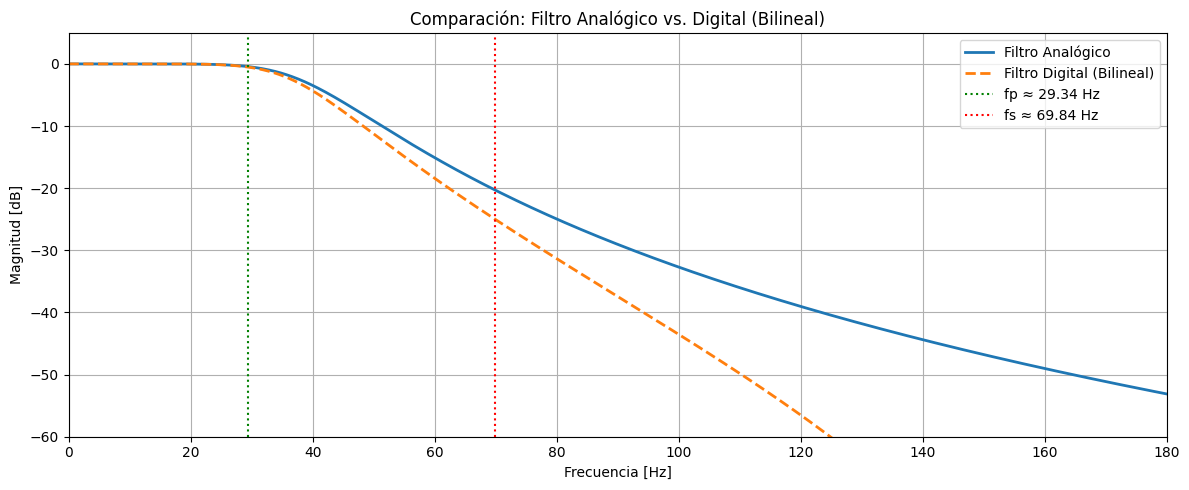

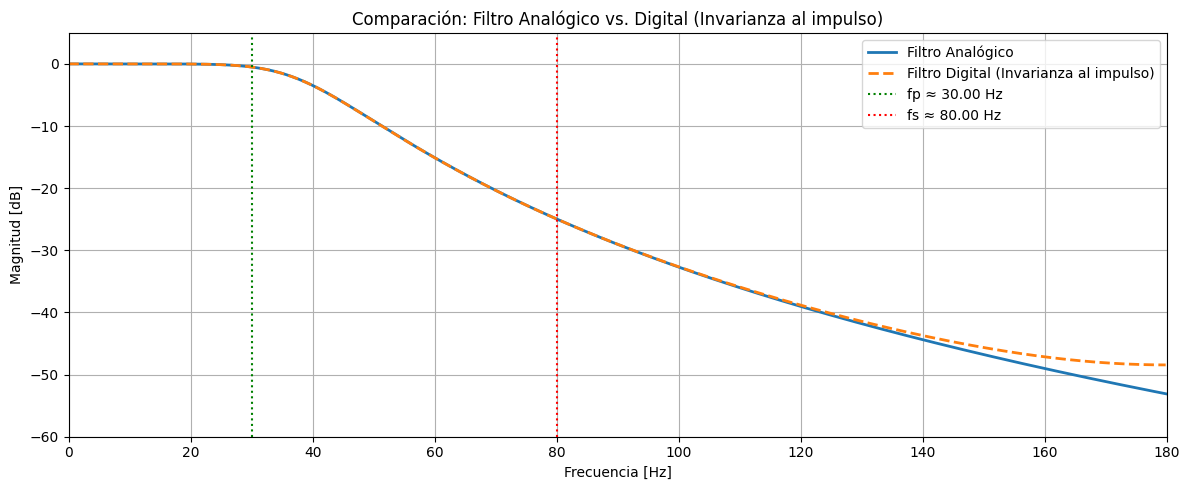

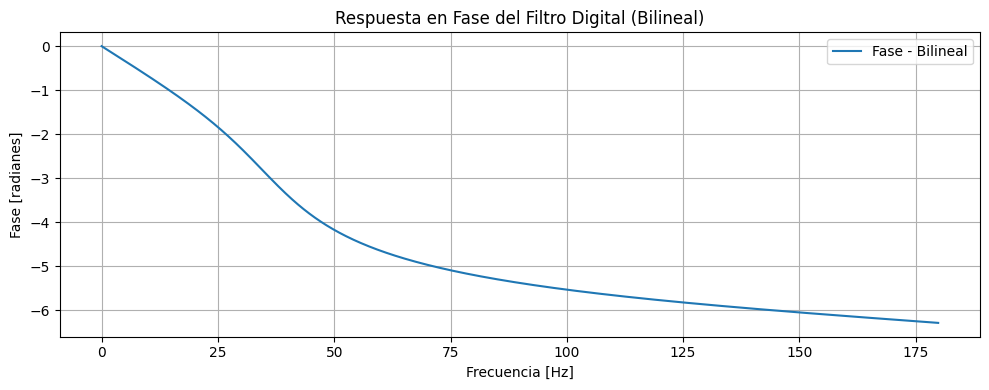

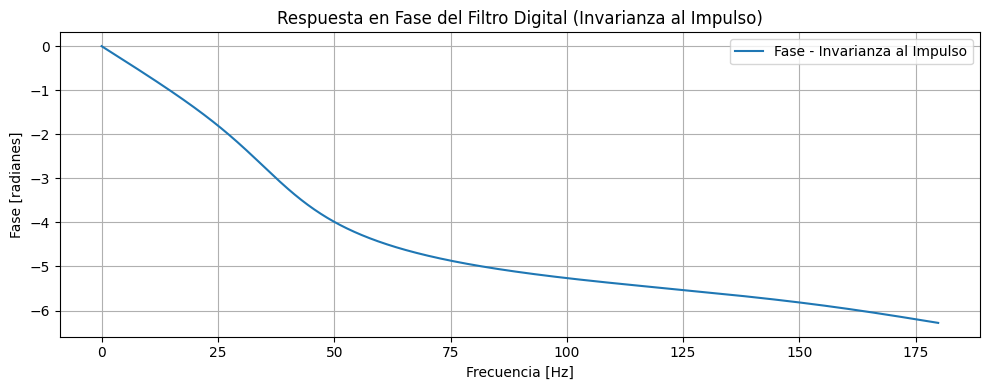

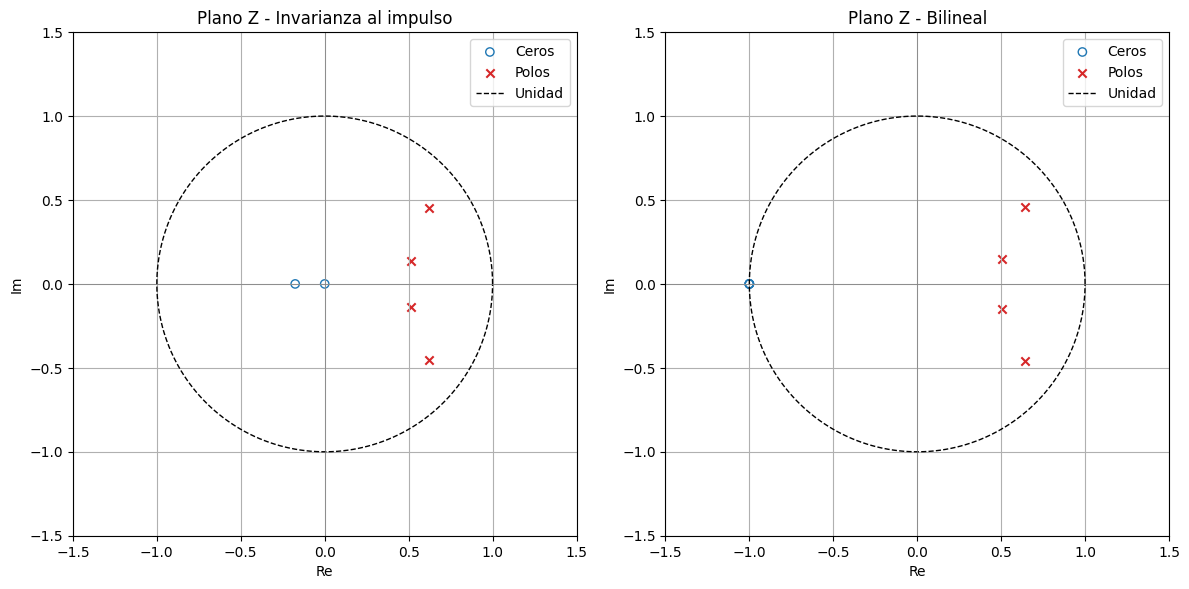

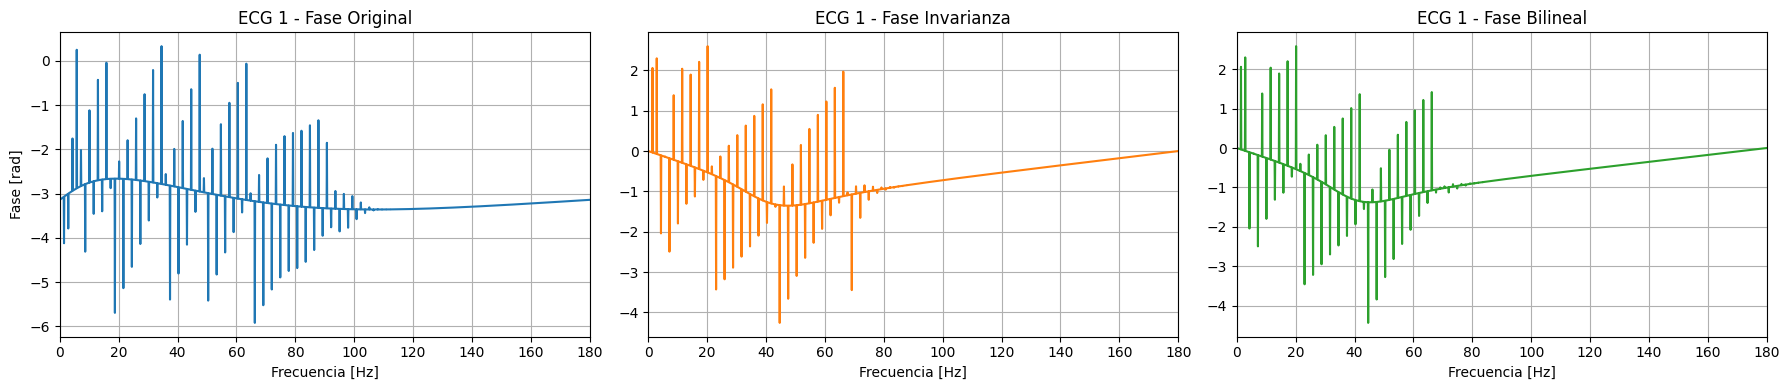

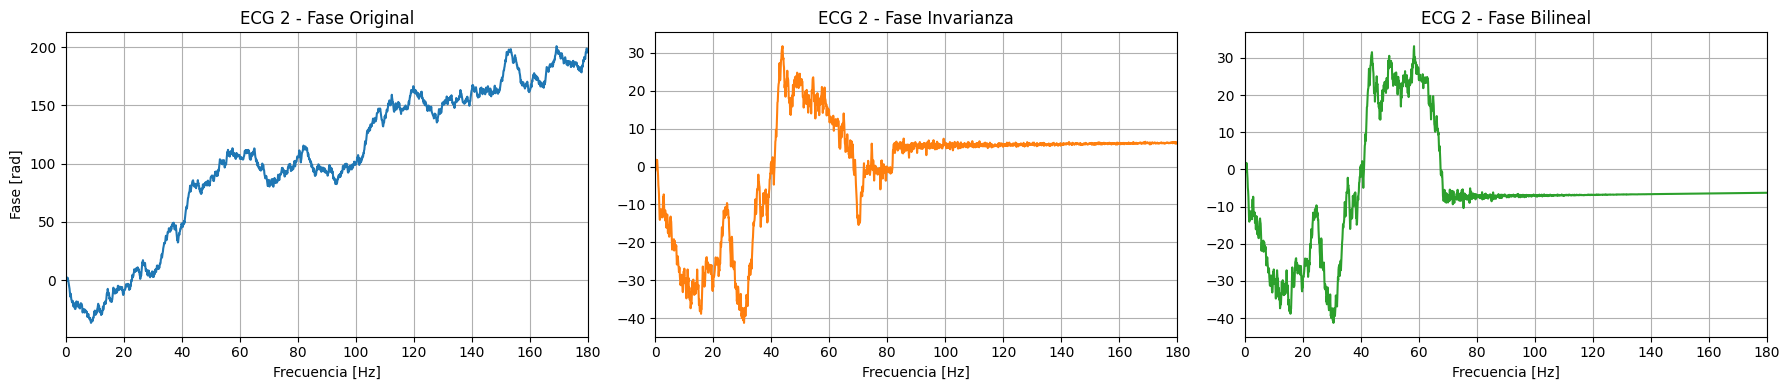

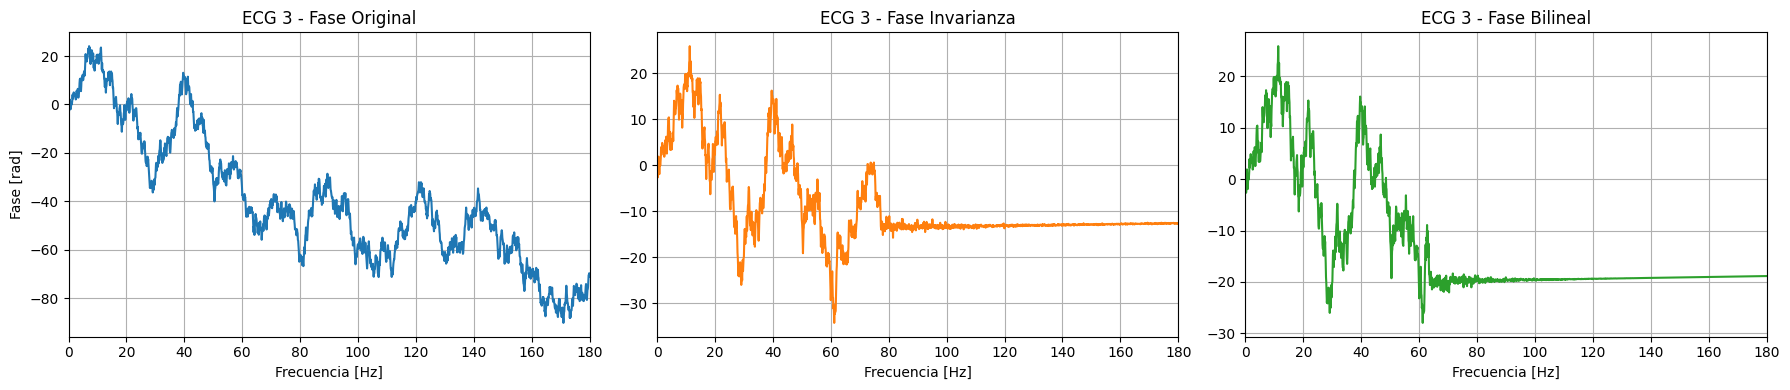

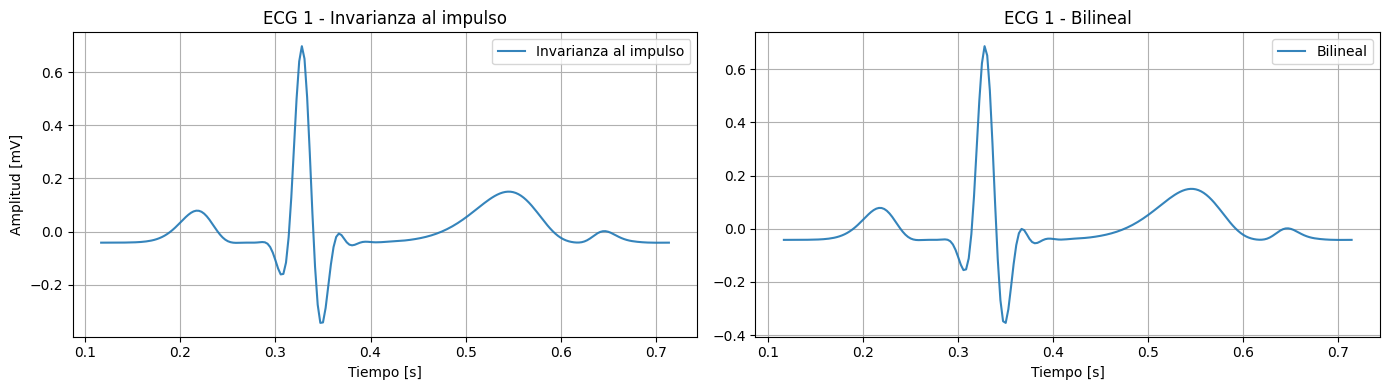

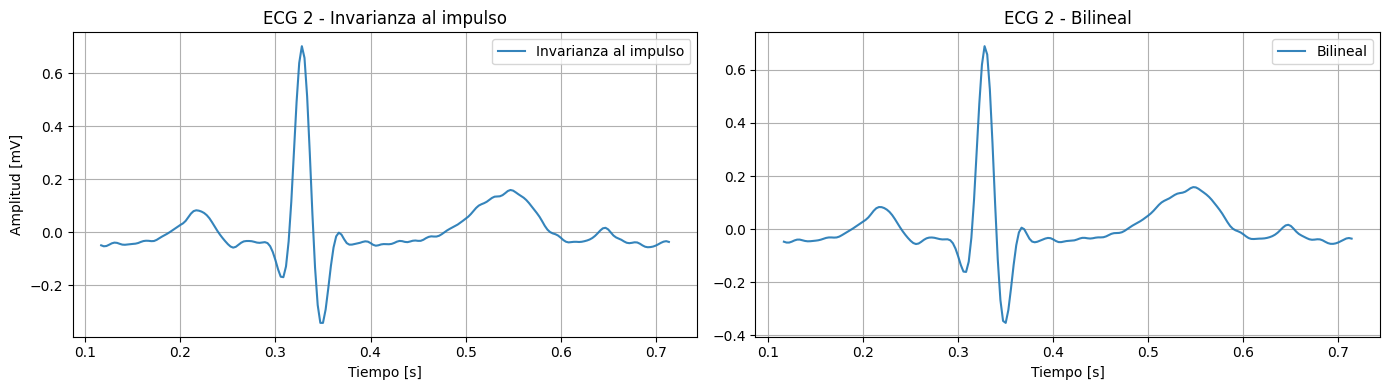

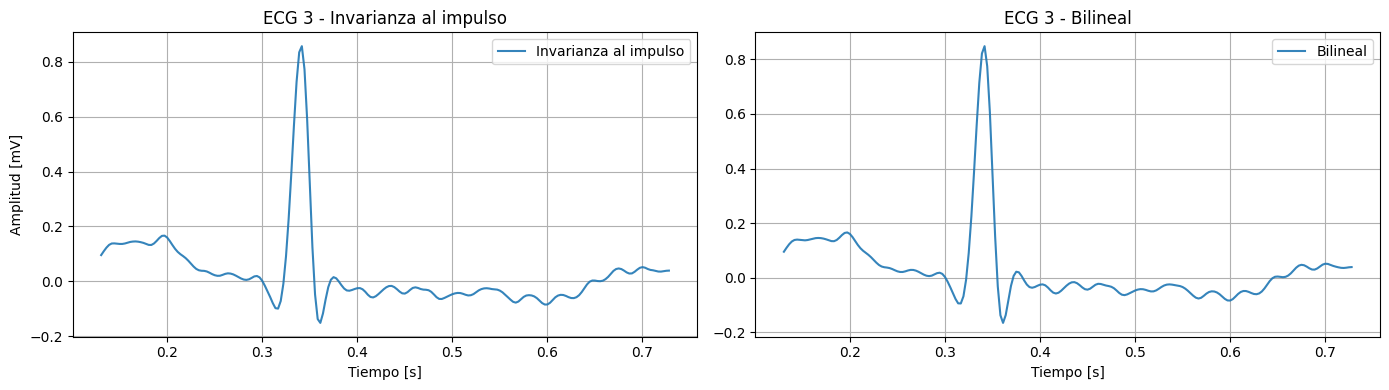

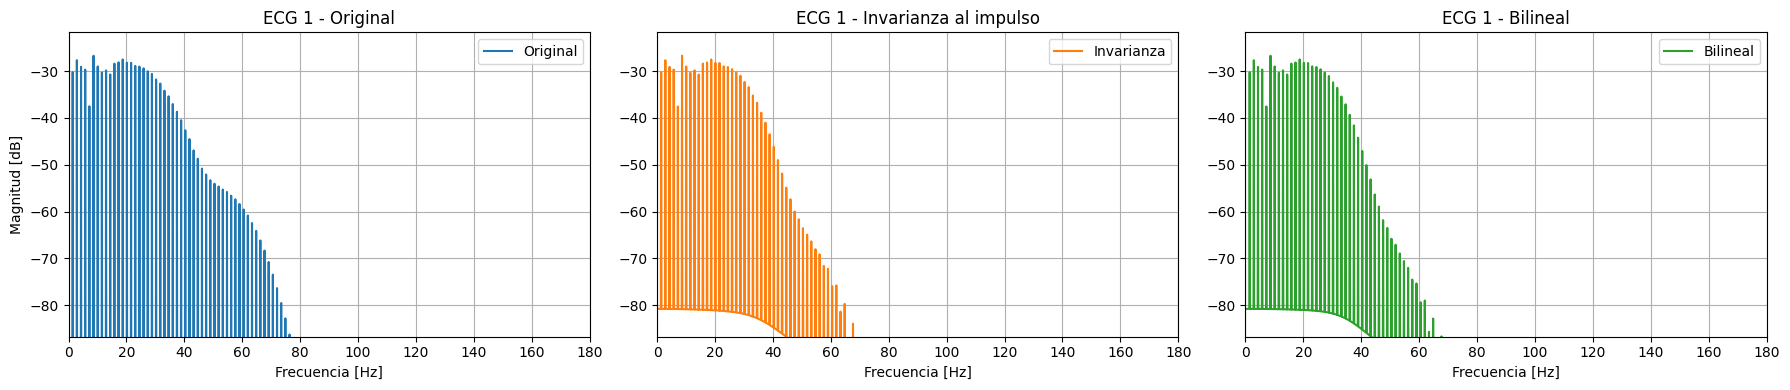

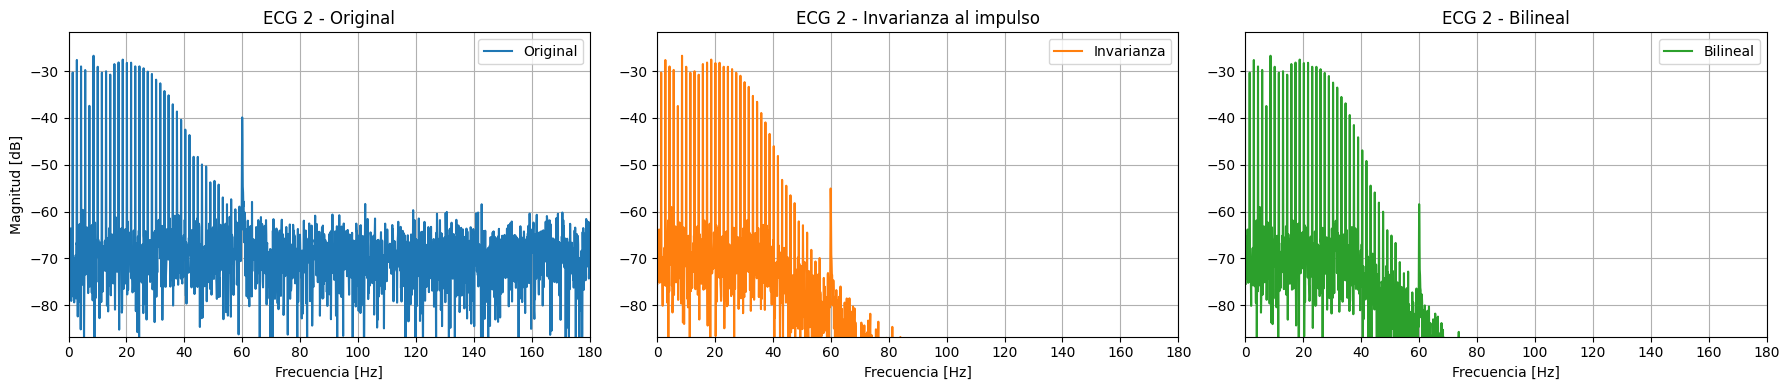

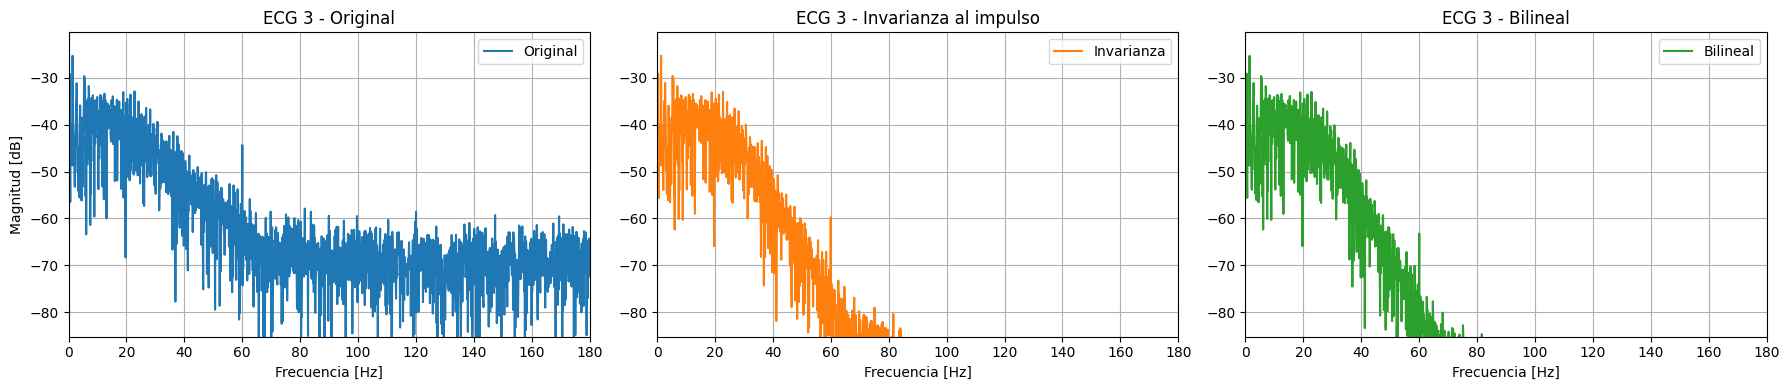

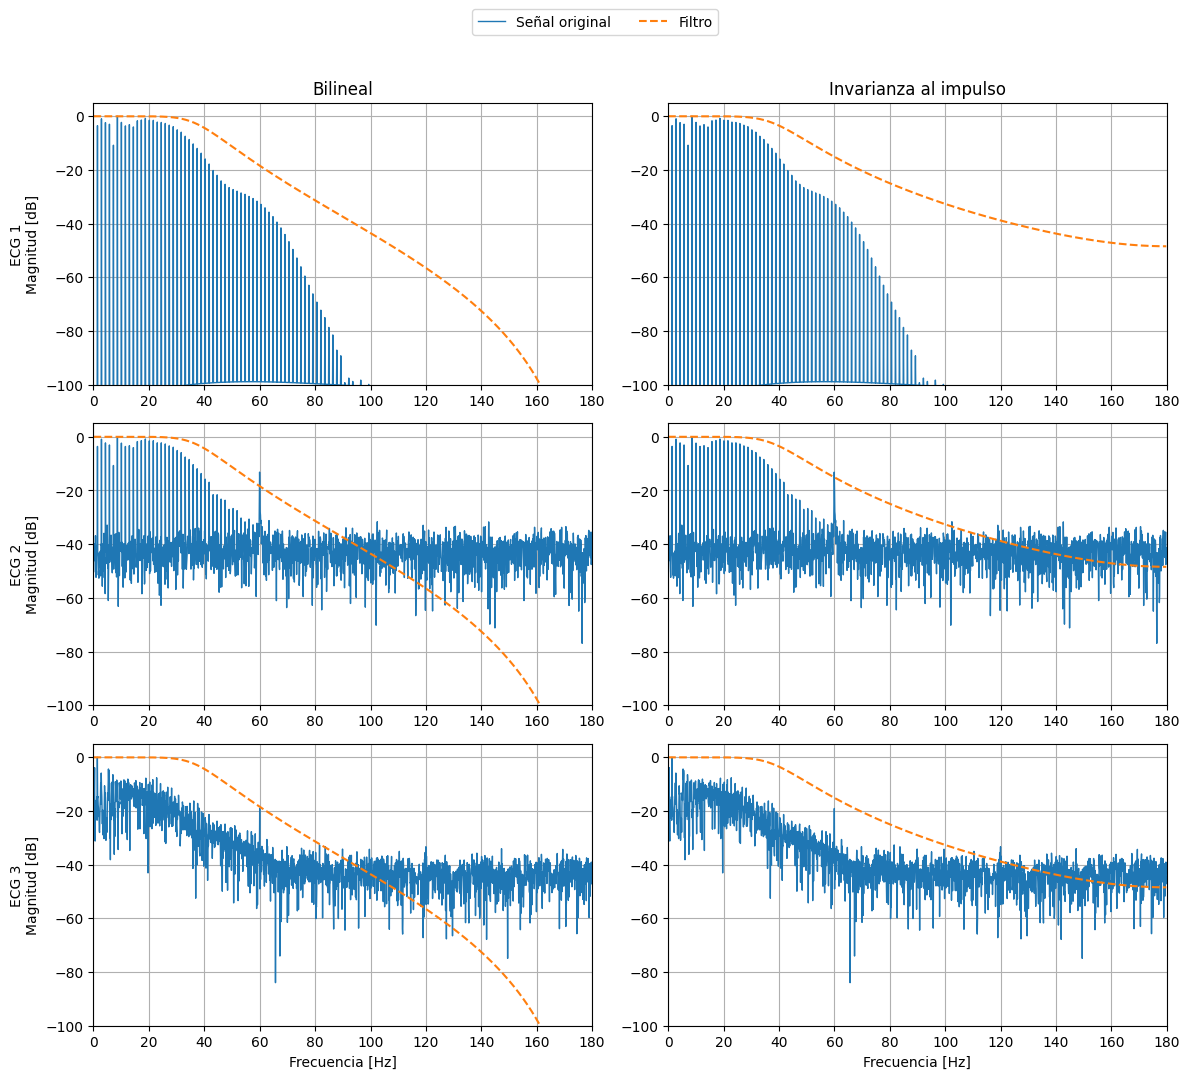

In [65]:
# === PARÁMETROS DE DISEÑO ===
fs = 360           # Frecuencia de muestreo (Hz)
fp = 30            # Frecuencia de paso deseada (Hz)
fb = 80            # Frecuencia de rechazo deseada (Hz)
Ap = 0.5           # Atenuación máxima en banda de paso (dB)
As = 20            # Atenuación mínima en banda de rechazo (dB)

# === 1. Diseñar filtro analógico sin prewarping (neutro para ambos métodos) ===
wp = 2 * np.pi * fp
ws = 2 * np.pi * fb
n, wn = buttord(wp, ws, Ap, As, analog=True)
b, a = butter(n, wn, btype='low', analog=True)

print(f"Orden del filtro analógico: {n}")
print(f"Frecuencia de corte analógica (rad/s): {wn:.2f} ({wn / (2 * np.pi):.2f} Hz)")

# === 2. Transformar con método bilineal ===
bz_bilin, az_bilin = transformar_bilineal(b, a, fs)
fp_bilin, fs_bilin = calcular_frecuencias_digitales_warp(wp, ws, fs)

# === 3. Transformar con método de invarianza al impulso ===
bz_invar, az_invar = transformar_impulse_invariance(b, a, fs)
fp_invar = fp  # como no hay prewarping, se mantiene la original
fs_invar = fb

# === 4. Comparar respuestas en frecuencia ===
graficar_respuesta_frecuencia_comparada(b, a, bz_bilin, az_bilin, fs, fp_bilin, fs_bilin, metodo="Bilineal")
graficar_respuesta_frecuencia_comparada(b, a, bz_invar, az_invar, fs, fp_invar, fs_invar, metodo="Invarianza al impulso")

graficar_fase_filtro(bz_bilin, az_bilin, fs, metodo="Bilineal")
graficar_fase_filtro(bz_invar, az_invar, fs, metodo="Invarianza al Impulso")

# === 5. Aplicar filtros a las señales reales ===
senales_filtradas_bilin = [lfilter(bz_bilin, az_bilin, s) for s in senales]
senales_filtradas_invar = [lfilter(bz_invar, az_invar, s) for s in senales]

graficar_polos_ceros_digitales_separados(
    bz_invar, az_invar,
    bz_bilin, az_bilin,
    metodo1="Invarianza al impulso",
    metodo2="Bilineal"
)

graficar_fase_en_columnas(
    senales,
    senales_filtradas_invar,
    senales_filtradas_bilin,
    fs,
    fmax=180
)


# === 6. Comparar señales en el tiempo ===
comparar_metodos_tiempo(
    senales,
    senales_filtradas_invar,
    senales_filtradas_bilin,
    fs,
    metodo1="Invarianza al impulso",
    metodo2="Bilineal",
    solo_filtradas=True
)

# === 7. Comparar espectros ===
comparar_fft_metodos(
    senales,
    senales_filtradas_invar,
    senales_filtradas_bilin,
    fs,
    fmax=180  # Se puede ajustar si se desea
)

graficar_superposicion_espectros(
    senales,
    [(bz_bilin, az_bilin), (bz_invar, az_invar)],
    fs=fs,
    fmax=180,
    etiquetas_filtros=["Bilineal", "Invarianza al impulso"]
)



ACTIVIDAD 3 - PROCESAMIENTO EN TIEMPO REAL

In [7]:
import time
import numpy as np


def celda_segundo_orden(xn, coef, estado):
    """
    Aplica una celda de segundo orden (forma directa transpuesta II) a una muestra.

    Esta función implementa un filtro IIR de orden 2 sobre una única muestra, usando el
    estado interno del filtro y los coeficientes normalizados.

    Args:
        xn (float): Muestra de entrada actual.
        coef (tuple): Coeficientes del filtro en la forma (b0, b1, b2, a1, a2),
                      con a0 normalizado a 1.
        estado (list of float): Estado interno de la celda, como [w1, w2] (memorias).

    Returns:
        float: Muestra de salida filtrada.
    """
    b0, b1, b2, a1, a2 = coef
    w1, w2 = estado
    wn = xn - a1 * w1 - a2 * w2
    yn = b0 * wn + b1 * w1 + b2 * w2
    estado[1] = w1
    estado[0] = wn
    return yn


def filtro_cascada(xn, celdas_coef, estados):
    """
    Aplica una cadena de celdas de segundo orden en cascada a una muestra.

    Cada celda procesa la muestra secuencialmente, y su salida se convierte en la
    entrada de la siguiente celda. Esto permite implementar filtros complejos
    como combinaciones de filtros Notch, pasa bajos, etc.

    Args:
        xn (float): Muestra de entrada actual.
        celdas_coef (list of tuples): Lista de coeficientes (b0, b1, b2, a1, a2)
                                      para cada celda del filtro.
        estados (list of [float, float]): Lista de estados internos [w1, w2]
                                          para cada celda.

    Returns:
        float: Muestra de salida final después de pasar por todas las celdas.
    """
    for i in range(len(celdas_coef)):
        xn = celda_segundo_orden(xn, celdas_coef[i], estados[i])
    return xn


def procesar_senal(senal, celdas_coef):
    """
    Procesa una señal completa muestra a muestra mediante un sistema en cascada.

    La señal se procesa secuencialmente, aplicando cada muestra a todas las
    celdas del filtro en cascada. Se mide además el tiempo total de ejecución
    y el tiempo promedio por muestra, útil para evaluar rendimiento.

    Args:
        senal (array-like): Señal digital de entrada (1D).
        celdas_coef (list of tuples): Lista de coeficientes (b0, b1, b2, a1, a2)
                                      para cada celda en cascada.

    Returns:
        tuple:
            - np.ndarray: Señal de salida filtrada (misma longitud que la entrada).
            - float: Tiempo total de procesamiento (en segundos).
            - float: Tiempo promedio por muestra (en microsegundos).
    """
    estados = [[0.0, 0.0] for _ in celdas_coef]
    salida = []

    t0 = time.perf_counter()

    for xn in senal:
        yn = filtro_cascada(xn, celdas_coef, estados)
        salida.append(yn)

    t1 = time.perf_counter()

    tiempo_total = t1 - t0
    tiempo_por_muestra = tiempo_total / len(senal) * 1e6  # µs

    return np.array(salida), tiempo_total, tiempo_por_muestra

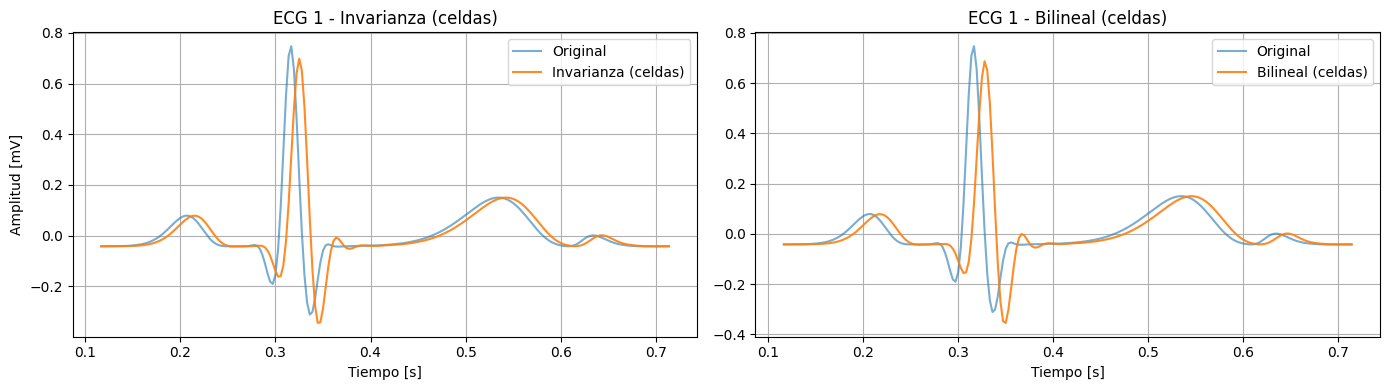

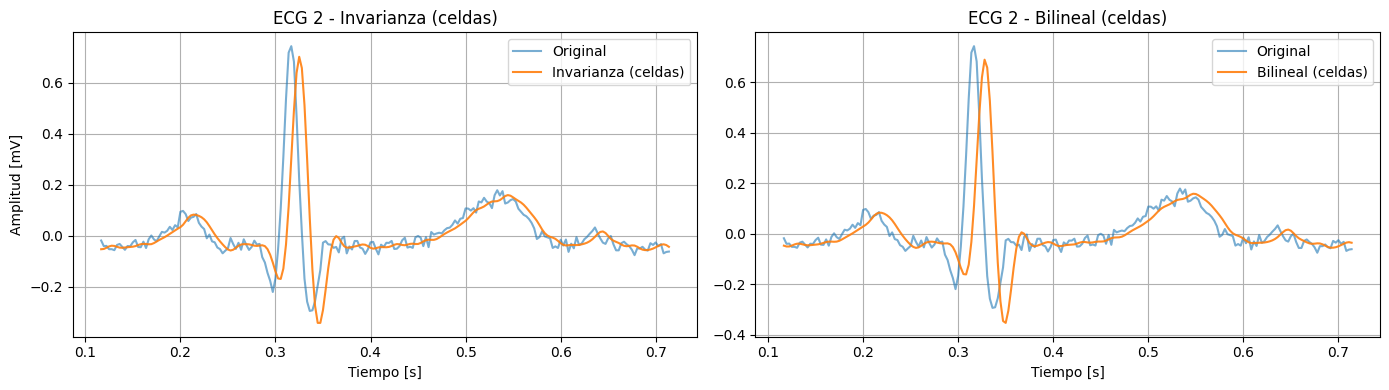

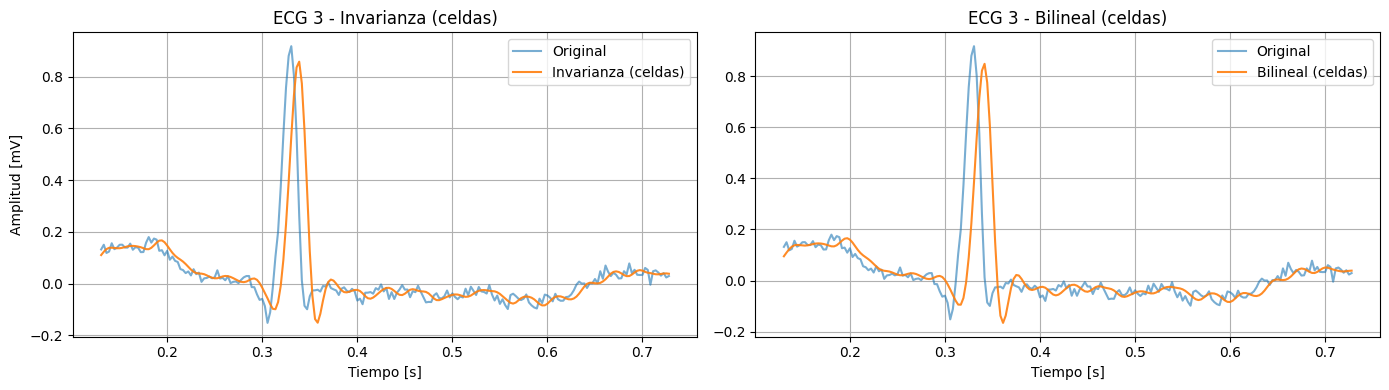

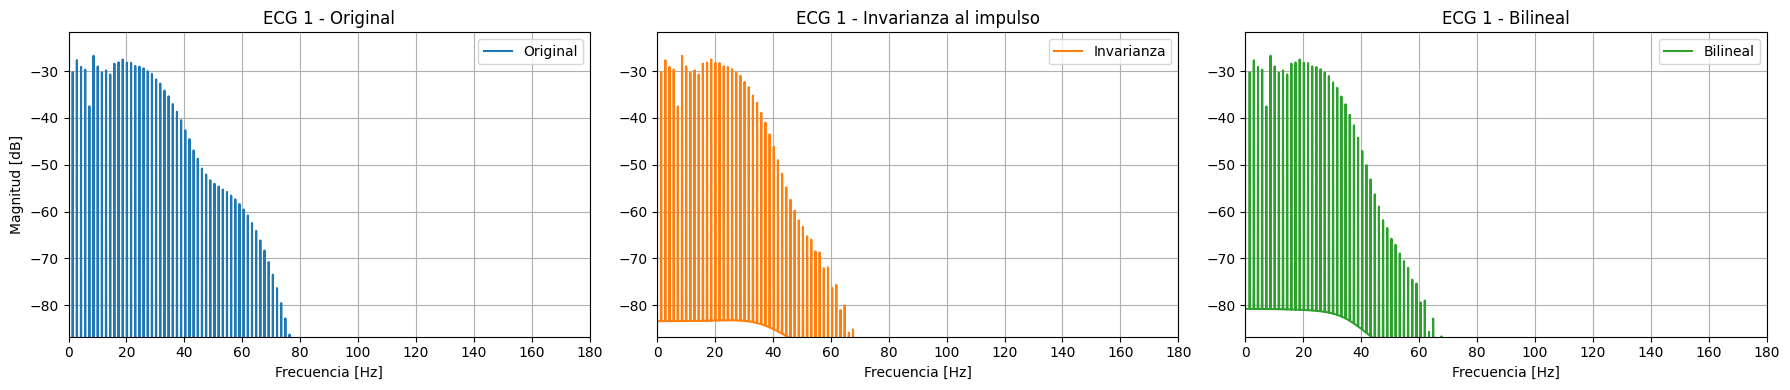

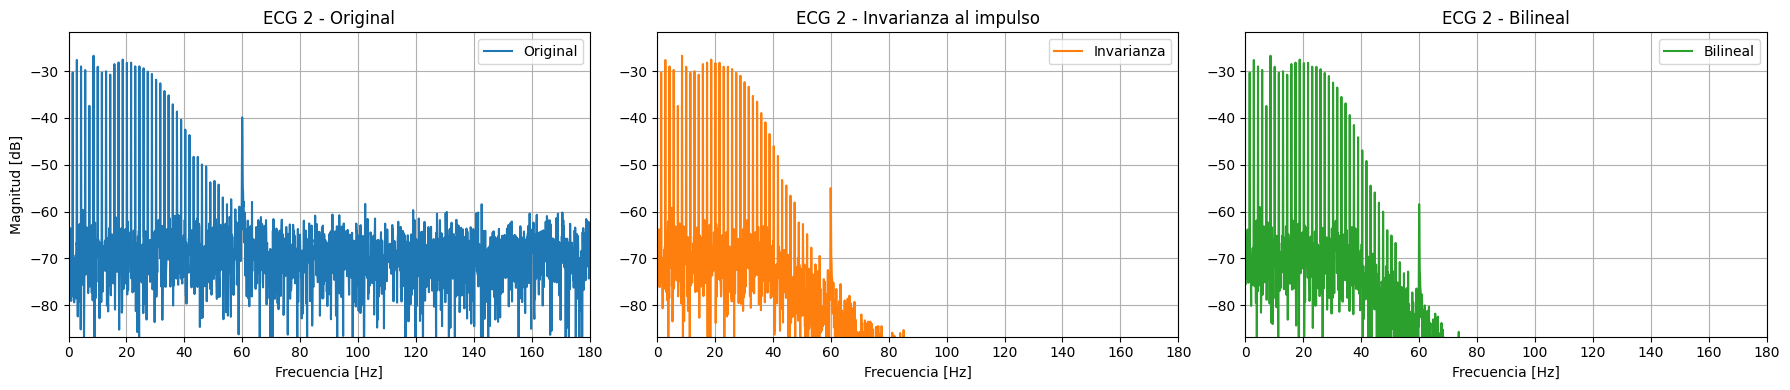

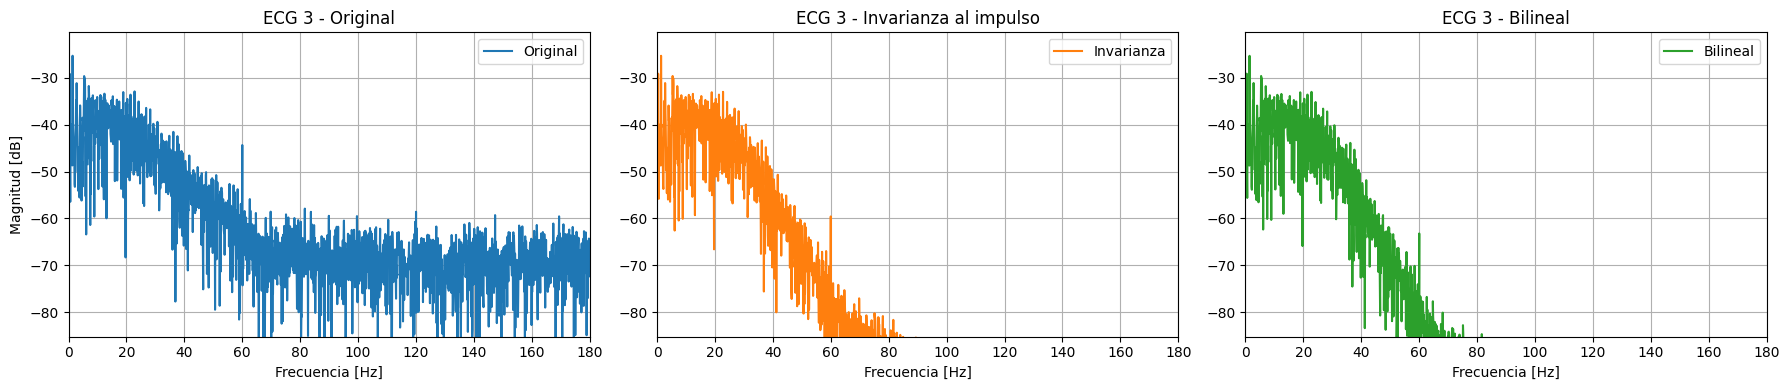

In [25]:
from scipy.signal import tf2sos
from copy import deepcopy

# === Conversión de coeficientes a celdas tipo II transpuestas ===
celdas_bilin = [(s[0], s[1], s[2], s[4], s[5]) for s in tf2sos(bz_bilin, az_bilin)]
celdas_invar = [(s[0], s[1], s[2], s[4], s[5]) for s in tf2sos(bz_invar, az_invar)]

# === Procesamiento de las señales usando las celdas ===
senales_filtradas_bilin_celdas = [
    procesar_senal(s, deepcopy(celdas_bilin))[0] for s in senales
]
senales_filtradas_invar_celdas = [
    procesar_senal(s, deepcopy(celdas_invar))[0] for s in senales
]

# === Comparación temporal entre ambas implementaciones por celdas ===
comparar_metodos_tiempo(
    senales,
    senales_filtradas_invar_celdas,
    senales_filtradas_bilin_celdas,
    fs,
    metodo1="Invarianza (celdas)",
    metodo2="Bilineal (celdas)",
    solo_filtradas=False
)

# === Comparación espectral entre ambas implementaciones por celdas ===
comparar_fft_metodos(
    senales,
    senales_filtradas_invar_celdas,
    senales_filtradas_bilin_celdas,
    fs,
    fmax=180
)


Primer borrador que funciona

In [ ]:
from scipy.signal import buttord, butter, bilinear, freqz, freqs, tf2zpk
import numpy as np
import matplotlib.pyplot as plt

fs = 360  # Frecuencia de muestreo en Hz

# === Frecuencias digitales deseadas (Hz)
fp = 30
fs_ = 90

# Obtener ceros y polos del filtro analógico
z, p, k = tf2zpk(b, a)

# === Prewarping ===
wp = 2 * fs * np.tan(np.pi * fp / fs)  # rad/s
ws = 2 * fs * np.tan(np.pi * fs_ / fs)  # rad/s

# Atenuaciones (dB)
Ap = 0.5  # zona de paso
As = 10   # zona de rechazo

# === Diseño analógico ===
n, wn = buttord(wp, ws, Ap, As, analog=True)
print(f"Orden del filtro analógico: {n}")
print(f"Frecuencia wp (rad/s): {wp:.2f} ({wp / (2 * np.pi):.2f} Hz)")
print(f"Frecuencia ws (rad/s): {ws:.2f} ({ws / (2 * np.pi):.2f} Hz)")
print(f"Frecuencia de corte (rad/s): {wn:.2f} ({wn / (2 * np.pi):.2f} Hz)")

b, a = butter(n, wn, btype='low', analog=True)

# Graficar en el plano s
graficar_polos_ceros(z, p, plano="s")

In [ ]:
# === Transformación por invarianza al impulso ===
from scipy.signal import cont2discrete, freqz, freqs, lfilter
import numpy as np
import matplotlib.pyplot as plt

dt = 1 / fs                       # Período de muestreo
bz, az, _ = cont2discrete((b, a), dt, method='impulse')
bz = bz.flatten()                 # (1×N) → 1-D

print("Coeficientes del filtro digital (invarianza al impulso):")
print("bz =", bz)
print("az =", az)

# === Frecuencias digitales asociadas (invarianza al impulso) ===
# Aquí la correspondencia f_digital ≈ f_analógica (sin warping)
fp_digital = fp
fs_digital = fs_

print("\n=== Especificaciones del Filtro Digital (Imp. Invariance) ===")
print(f"Frecuencia de paso (digital): {fp_digital:.2f} Hz")
print(f"Frecuencia de rechazo (digital): {fs_digital:.2f} Hz")

# === Respuesta en frecuencia del filtro analógico ===
w_analog = np.linspace(0.01, fs * np.pi, 1000)   # rad/s
frecs_analog = w_analog / (2 * np.pi)            # Hz
_, h_analog = freqs(b, a, w_analog)
h_analog_db = 20 * np.log10(np.abs(h_analog))

# === Respuesta en frecuencia del filtro digital (impulse invariance) ===
w_digital, h_digital = freqz(bz, az, worN=1024)
frecs_digital = w_digital * fs / (2 * np.pi)     # Hz
h_digital_db = 20 * np.log10(np.abs(h_digital))

# === Gráfico comparativo ===
plt.figure(figsize=(12, 5))
plt.plot(frecs_analog, h_analog_db, label="Filtro Analógico", linewidth=2)
plt.plot(frecs_digital, h_digital_db, "--", label="Filtro Digital (invarianza al impulso)", linewidth=2)
plt.axvline(fp_digital, color="green", linestyle=":", label=f"fp_digital ≈ {fp_digital:.2f} Hz")
plt.axvline(fs_digital, color="red", linestyle=":", label=f"fs_digital ≈ {fs_digital:.2f} Hz")
plt.title("Comparación: Filtro Analógico vs. Filtro Digital (Imp. Invariance)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid(True)
plt.xlim(0, fs / 2)
plt.ylim(-60, 5)
plt.legend()
plt.tight_layout()
plt.show()

graficar_ciclo_filtrado(senales, bz, az, fs, metodo="Invarianza al impulso")
graficar_fft_comparativa(senales, senales_filtradas, fs, fmax=180, metodo="Invarianza al impulso")

In [ ]:
# === Transformación bilineal ===
bz, az = bilinear(b, a, fs)
print("Coeficientes del filtro digital (bilineal):")
print("bz =", bz)
print("az =", az)

# === Conversión inversa para obtener frecuencias digitales asociadas ===
fp_digital = (fs / np.pi) * np.arctan(wp / (2 * fs))
fs_digital = (fs / np.pi) * np.arctan(ws / (2 * fs))

print("\n=== Especificaciones del Filtro Digital (Bilineal) ===")
print(f"Frecuencia de paso (digital): {fp_digital:.2f} Hz")
print(f"Frecuencia de rechazo (digital): {fs_digital:.2f} Hz")

# === Respuesta en frecuencia del filtro analógico ===
w_analog = np.linspace(0.01, fs * np.pi, 1000)
frecs_analog = w_analog / (2 * np.pi)
_, h_analog = freqs(b, a, w_analog)
h_analog_db = 20 * np.log10(np.abs(h_analog))

# === Respuesta en frecuencia del filtro digital ===
w_digital, h_digital = freqz(bz, az, worN=1024)
frecs_digital = w_digital * fs / (2 * np.pi)
h_digital_db = 20 * np.log10(np.abs(h_digital))

# === Gráfico comparativo ===
plt.figure(figsize=(12, 5))
plt.plot(frecs_analog, h_analog_db, label="Filtro Analógico", linewidth=2)
plt.plot(frecs_digital, h_digital_db, "--", label="Filtro Digital (bilineal)", linewidth=2)
plt.axvline(fp_digital, color="green", linestyle=":", label=f"fp_digital ≈ {fp_digital:.2f} Hz")
plt.axvline(fs_digital, color="red", linestyle=":", label=f"fs_digital ≈ {fs_digital:.2f} Hz")
plt.title("Comparación: Filtro Analógico vs. Filtro Digital (Bilineal)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid(True)
plt.xlim(0, fs / 2)
plt.ylim(-60, 5)
plt.legend()
plt.tight_layout()
plt.show()

graficar_ciclo_filtrado(senales, bz, az, fs, metodo="Transformada Bilineal")
graficar_fft_comparativa(senales, senales_filtradas, fs, fmax=180, metodo="Transformada Bilineal")